### Testing resample() function ###
~~Starting with some random y data (gaussian) with shape of [2000,5]~~

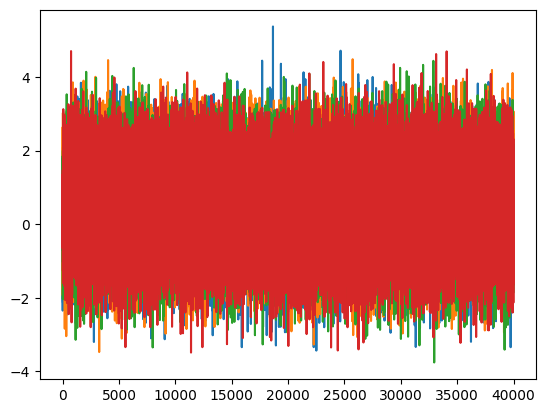

In [ ]:
import sys
import os
upper_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(upper_dir)
from TestDataAugmentation import generateData, plotData
from neuraldecoding.dataaugmentation import DataAugmentation as da
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kstest, norm


N = 40000
mu_original = 0.0
sigma_original = 100.0
#y = np.random.uniform(-400, 400, size=(N, 5))
#y = np.random.normal(mu_original, sigma_original, size=(N, 5))
# with open(os.path.join('C:\\Files\\UM\\ND\\DataAugmentation\\Data', '2024-02-05_preprocess.pkl'), 'rb') as f:
#     data_CO, data_RD = pickle.load(f)
# x = data_CO['sbp']
# y = data_CO['finger_kinematics']
# plt.plot(y)

y = np.random.normal(0.5, 1, size=(N, 4))
plt.plot(y)

In [2]:
print(y.shape)
print(y.max())
print(y.min())

(40000, 4)
5.371171181800882
-3.759023001215197


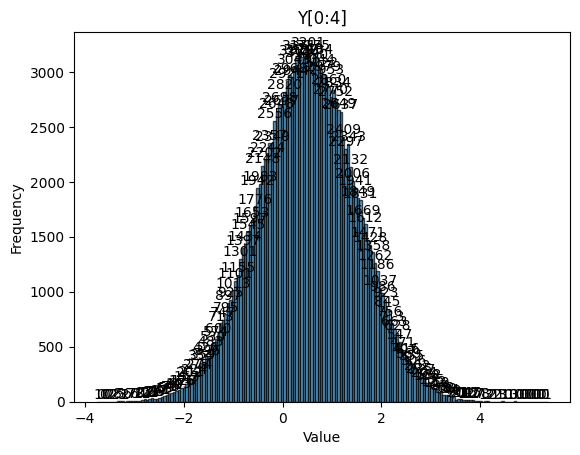

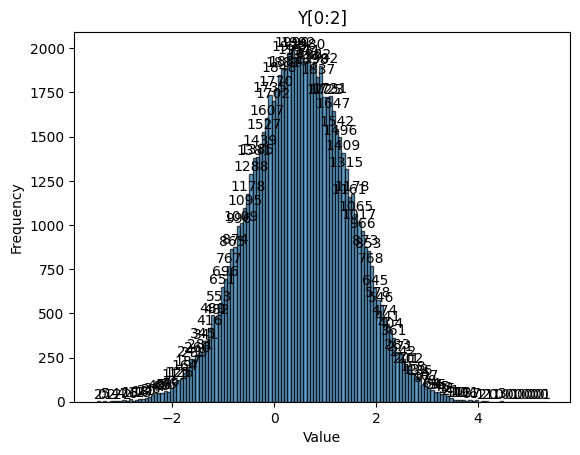

In [3]:
counts, bins, patches = plt.hist(y.flatten(), bins='auto', edgecolor='black', alpha=0.7)
    
#x = np.linspace(min(result_array.all()), max(result_array.all()), 500)

for count, bin_edge in zip(counts, bins):
    bin_center = bin_edge + (bins[1] - bins[0]) / 2
    plt.text(bin_center, count, f'{int(count)}', ha='center', va='bottom')

plt.title(f'Y[0:4]')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

counts, bins, patches = plt.hist(y[:,0:2].flatten(), bins='auto', edgecolor='black', alpha=0.7)
    
#x = np.linspace(min(result_array.all()), max(result_array.all()), 500)

for count, bin_edge in zip(counts, bins):
    bin_center = bin_edge + (bins[1] - bins[0]) / 2
    plt.text(bin_center, count, f'{int(count)}', ha='center', va='bottom')

plt.title(f'Y[0:2]')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

~~### single dimension of y testing,  potential  problem~~

~~1)~~

~~testing method: resample using y, replace index with values, fit distribution and compare mu and sigma.~~
~~potential problem: spikes in historgram occurs, wrong mu and sigma values. possible that it comes from normalization from vy to ny in resample function.~~
~~```ny = (vy - np.mean(vy))/np.std(vy)``` which shrinks the data into a small region where only the spike values are the closest to the target distribution.~~
~~Fix shown later in this section does fix it by removing this line.~~

~~what is the reason for the normalization to exist here?~~

~~2)~~

~~std_gauss:~~

~~this is the one directly taken from code as well.~~

~~```pd_vec = 2*np.random.randn(num_resamp,int(vy.shape[1]))```~~
~~why is there a 2* on the distribution?~~

~~fix shown later fix this by removing it.~~

# ~~fix?~~
not a fix, just leaving it here to rot

In [4]:
from scipy.spatial import KDTree
def resample_fix(Y,
             num_resamp_floor = 2e4,
             method = None,
             start = None,
             end = None,
             **kwargs
             ):
             # TODO: use dictionary to replace if statements
    """
        Resample data to most closely match a specified distribution (tri, gauss, uni)
        generic parameter to specify the dimension to resample on. 
        specify which dimension to resample on, make sure able to resample multiple inputs (other than x but can resamlpe both x and y based on specified dimensions of resampling inside y)
        Args:
            Y (ndarray): numpy array of size [N, numfeats]
            num_resamp_floor (int): Default 2e4 (as PyBMI code), minimum number of samples resampled
            start (int): Default None (not slicing), starting index for the resampling dimension 
            end (int): Default None (not slicing), ending index for the resampling dimension 
            method (string): Default None, Target distribution for resampling, current options: 'gauss', 'tri', 'uni', None
            **kwargs: Additional args for parameters of distribution. ('mean', 'std' for gauss; 'left', 'mode', 'right' for tri; 'low', 'high' for uni)
            #TODO future: add more generic code to customize distribution
        Returns:
            idx (ndarray): Resampling indices for given distribution (None if method = None)
    """
    num_resamp = int(np.max((num_resamp_floor,Y.shape[0])))

    vy = Y[:,start:end] #pull off velocities
        # N.B. In the original code the slicing should correspond to start = int(Y.shape[1] / 2), end = None
    ny = vy #line of fix

    if isinstance(method, str):
        if method == 'std_gauss':
            pd_vec = np.random.randn(num_resamp,int(vy.shape[1]))
        elif method == 'gauss':
            mean = kwargs.get('mean')
            std = kwargs.get('std')
            if mean is None or std is None:
                raise ValueError("gauss method requires 'mean', and 'std'")
            pd_vec = np.random.normal(mean, std, (num_resamp,int(vy.shape[1])))
        elif method == 'tri':
            left = kwargs.get('left')
            mode = kwargs.get('mode')
            right = kwargs.get('right')
            if left is None or mode is None or right is None:
                raise ValueError("tri method requires 'left', 'mode', and 'right'")
            pd_vec = np.random.triangular(left, mode, right, (num_resamp,int(vy.shape[1])))
        elif method == 'uni':
            low = kwargs.get('low')
            high = kwargs.get('high')
            if low is None or high is None: 
                raise ValueError("uni method requires 'low', and 'high'")
            pd_vec = np.random.uniform(low, high, (num_resamp,int(vy.shape[1])))
        else:
            Warning("Not a valid distribution defaulting to None")
            pd_vec = None

    elif method == None:
        pd_vec = None
    else:
        Warning("Not a valid distribution, defaulting to None")
        pd_vec = None

    if pd_vec is not None:
        kdt = KDTree(ny)
        idx = kdt.query(pd_vec)[1]
    else:
        idx = None
    
    return idx

# Test Gaussian 1D

testing gaussian with mu = 0 and sigma = 1
(40000,)
(40000, 1)
        original mean = 0, fitted mean = -2.708944180085382e-17
        original std = 1, fitted std = 1.0
    passed
(40000, 1)


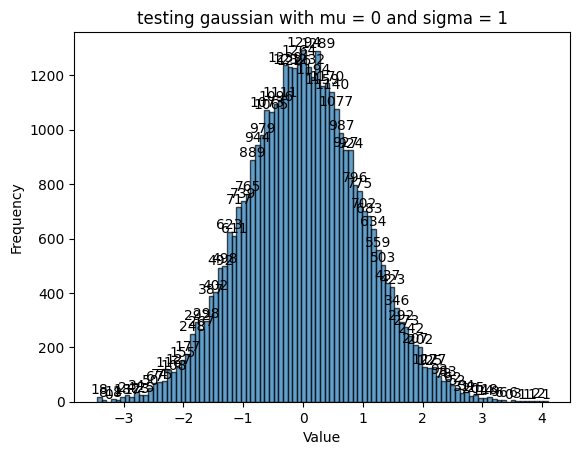

testing gaussian with mu = 0.1 and sigma = 0.3
(40000,)
(40000, 1)
        original mean = 0.1, fitted mean = 0.1
        original std = 0.3, fitted std = 0.3
    passed
(40000, 1)


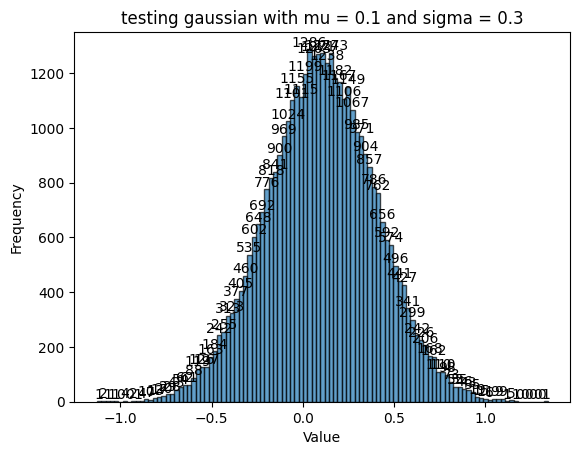

testing gaussian with mu = -0.1 and sigma = 0.3
(40000,)
(40000, 1)
        original mean = -0.1, fitted mean = -0.09999999999999999
        original std = 0.3, fitted std = 0.3
    passed
(40000, 1)


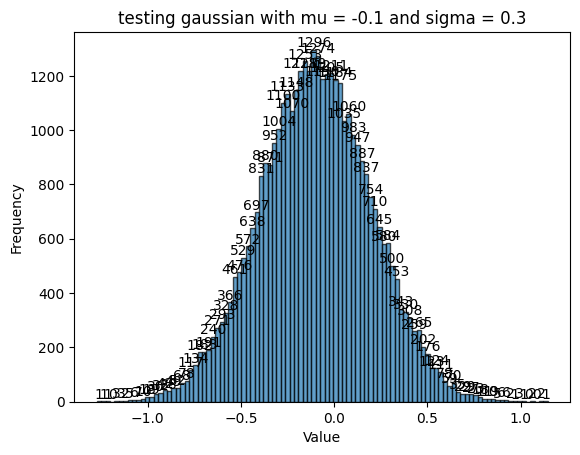

testing gaussian with mu = 0.1 and sigma = 1
(40000,)
(40000, 1)
        original mean = 0.1, fitted mean = 0.10000000000000005
        original std = 1, fitted std = 0.9999999999999999
    passed
(40000, 1)


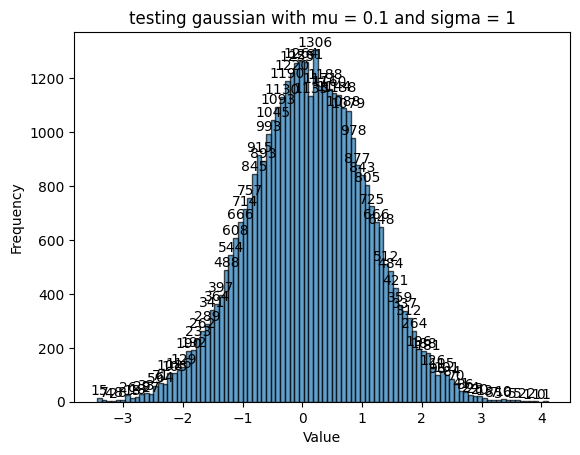

testing gaussian with mu = 0.1 and sigma = 3
(40000,)
(40000, 1)
        original mean = 0.1, fitted mean = 0.09999999999999995
        original std = 3, fitted std = 3.0
    passed
(40000, 1)


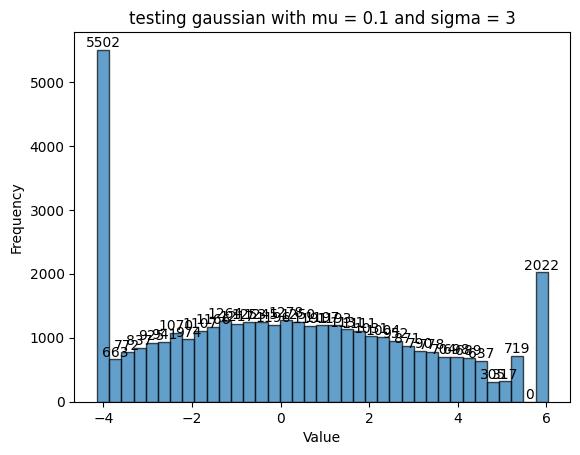

testing gaussian with mu = 9 and sigma = 9
(40000,)
(40000, 1)
        original mean = 9, fitted mean = 9.000000000000002
        original std = 9, fitted std = 9.0
    passed
(40000, 1)


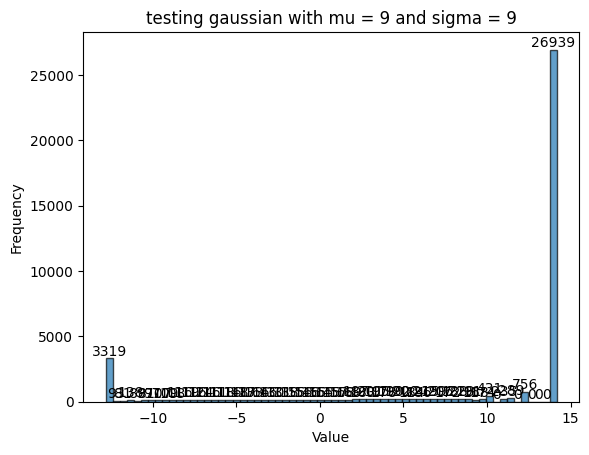

In [5]:
def test_gaussian(mu,sigma,threshold=0.1):
    print(f'testing gaussian with mu = {mu} and sigma = {sigma}')
    start = 0
    end = 1
    resample_returns = da.resample(y,method='gauss',start=start,end=end,mean=mu,std=sigma)
    print(resample_returns.shape)
    sampled_points = y[resample_returns, start:end]
    print(sampled_points.shape)
    
    sampled_points = (sampled_points - np.mean(sampled_points)) / np.std(sampled_points) 
    normalized_sampled_points = sampled_points * sigma + mu

    #normalized_sampled_points = sampled_points
    mu_hat, sigma_hat = norm.fit(normalized_sampled_points[:,:])

    print(f'        original mean = {mu}, fitted mean = {mu_hat}')
    print(f'        original std = {sigma}, fitted std = {sigma_hat}')
    print('    passed' if(abs(sigma_hat - sigma) <= threshold and abs(mu_hat - mu) <= threshold) else '    failed')

    
    result_array = normalized_sampled_points
    print(result_array.shape)
    counts, bins, patches = plt.hist(normalized_sampled_points, bins='auto', edgecolor='black', alpha=0.7)
    
    #x = np.linspace(min(result_array.all()), max(result_array.all()), 500)
    
    for count, bin_edge in zip(counts, bins):
        bin_center = bin_edge + (bins[1] - bins[0]) / 2
        plt.text(bin_center, count, f'{int(count)}', ha='center', va='bottom')

    plt.title(f'testing gaussian with mu = {mu} and sigma = {sigma}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

test_gaussian(0,1)
test_gaussian(0.1,0.3)
test_gaussian(-0.1,0.3)
test_gaussian(0.1,1)
test_gaussian(0.1,3)
test_gaussian(9,9)


# Test Gauss 2D

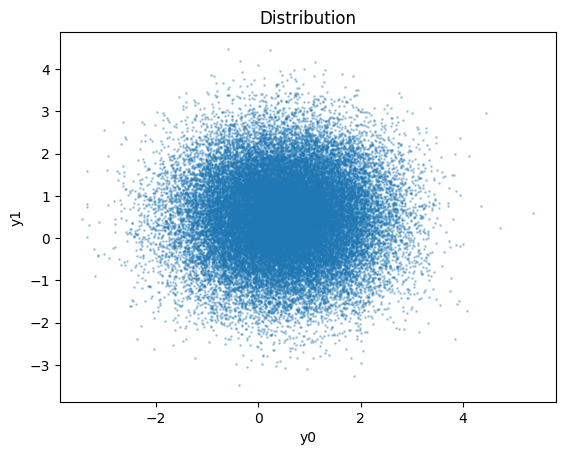

testing gaussian with mu = 0 and sigma = 1
(40000, 2)
        original mean = 0, fitted mean = 2.6645352591003758e-18
        original std = 1, fitted std = 0.9999999999999998
    passed


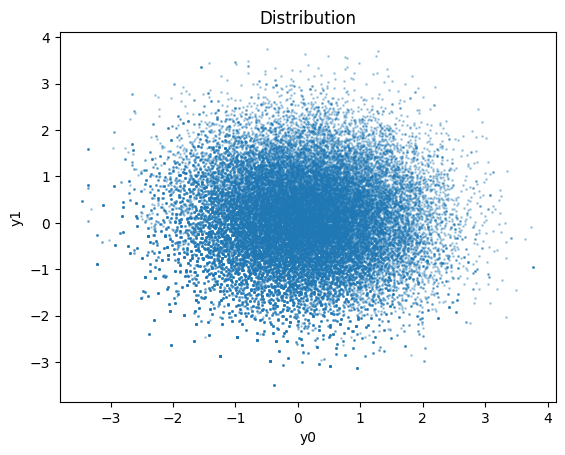

testing gaussian with mu = 0.1 and sigma = 0.3
(40000, 2)
        original mean = 0.1, fitted mean = 0.1
        original std = 0.3, fitted std = 0.30000000000000004
    passed


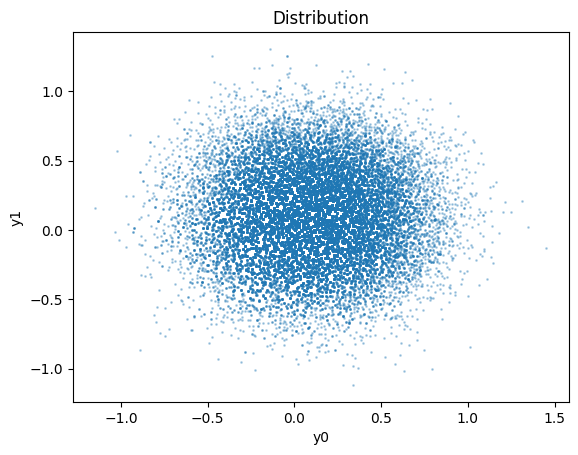

testing gaussian with mu = -0.1 and sigma = 0.3
(40000, 2)
        original mean = -0.1, fitted mean = -0.09999999999999998
        original std = 0.3, fitted std = 0.3
    passed


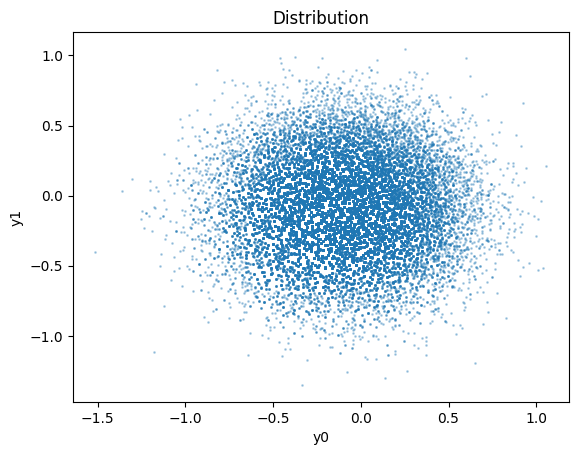

testing gaussian with mu = 0.1 and sigma = 1
(40000, 2)
        original mean = 0.1, fitted mean = 0.09999999999999999
        original std = 1, fitted std = 1.0
    passed


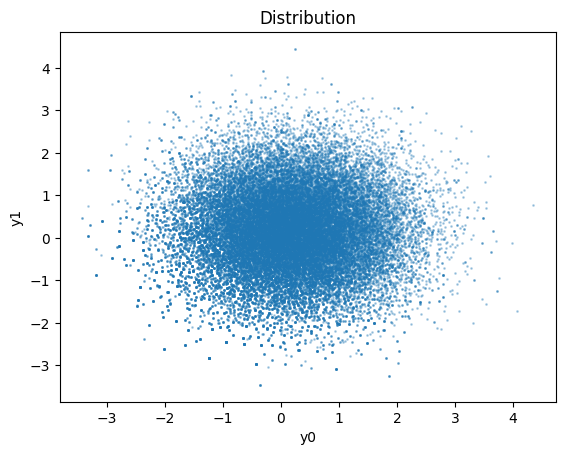

testing gaussian with mu = 0.1 and sigma = 3
(40000, 2)
        original mean = 0.1, fitted mean = 0.09999999999999999
        original std = 3, fitted std = 2.9999999999999996
    passed


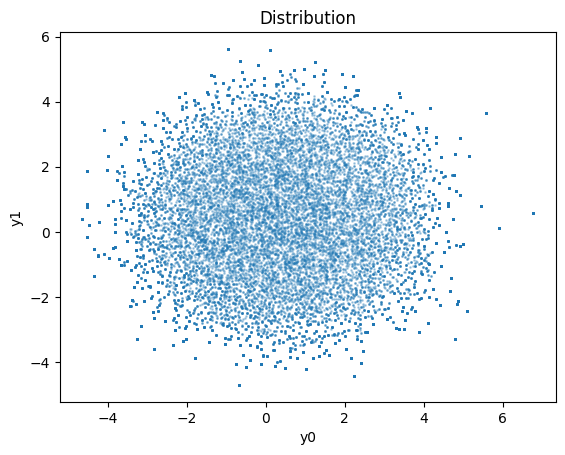

testing gaussian with mu = 9 and sigma = 9
(40000, 2)
        original mean = 9, fitted mean = 9.000000000000004
        original std = 9, fitted std = 9.0
    passed


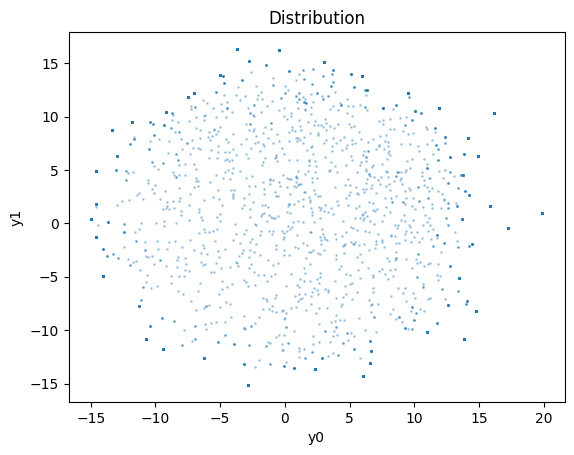

In [6]:

import scipy
def test_gaussian(mu,sigma,threshold=0.1):
    print(f'testing gaussian with mu = {mu} and sigma = {sigma}')
    start = 0
    end = 2
    resample_returns = da.resample(y,method='gauss',start=start,end=end,mean=mu,std=sigma)
    sampled_points = y[resample_returns, start:end]
    
    print(sampled_points.shape)
    sampled_points = (sampled_points - np.mean(sampled_points)) / np.std(sampled_points) 
    normalized_sampled_points = sampled_points * sigma + mu

    mu_hat, sigma_hat = norm.fit(normalized_sampled_points[:,:])
    print(f'        original mean = {mu}, fitted mean = {mu_hat}')
    print(f'        original std = {sigma}, fitted std = {sigma_hat}')
    print('    passed' if(abs(sigma_hat - sigma) <= threshold and abs(mu_hat - mu) <= threshold) else '    failed')

    plt.scatter(normalized_sampled_points[:, 0], normalized_sampled_points[:, 1], alpha=0.3, s=1)
    plt.xlabel('y0')
    plt.ylabel('y1')
    plt.title('Distribution')
    plt.show()

    # counts, bins, patches = plt.hist(normalized_sampled_points[:,0], bins='auto', edgecolor='black', alpha=0.7)
    
    # #x = np.linspace(min(result_array.all()), max(result_array.all()), 500)
    
    # for count, bin_edge in zip(counts, bins):
    #     bin_center = bin_edge + (bins[1] - bins[0]) / 2
    #     plt.text(bin_center, count, f'{int(count)}', ha='center', va='bottom')

    # plt.title(f'testing gaussian with mu = {mu} and sigma = {sigma} dim= 0')
    # plt.xlabel('Value')
    # plt.ylabel('Frequency')
    # plt.show()

    # counts, bins, patches = plt.hist(normalized_sampled_points[:,1], bins='auto', edgecolor='black', alpha=0.7)
    
    # #x = np.linspace(min(result_array.all()), max(result_array.all()), 500)
    
    # for count, bin_edge in zip(counts, bins):
    #     bin_center = bin_edge + (bins[1] - bins[0]) / 2
    #     plt.text(bin_center, count, f'{int(count)}', ha='center', va='bottom')

    # plt.title(f'testing gaussian with mu = {mu} and sigma = {sigma} dim= 1')
    # plt.xlabel('Value')
    # plt.ylabel('Frequency')
    # plt.show()
plt.scatter(y[:, 0], y[:, 1], alpha=0.3, s=1)
plt.xlabel('y0')
plt.ylabel('y1')
plt.title('Distribution')
plt.show()
test_gaussian(0,1)
test_gaussian(0.1,0.3)
test_gaussian(-0.1,0.3)
test_gaussian(0.1,1)
test_gaussian(0.1,3)
test_gaussian(9,9)

# Test Triangle 1D

In [7]:

import scipy
def test_triangle(left,mode,right,threshold=0.1):
    print(f'testing triangle with left = {left}, right = {right}, and mode = {mode}')
    resample_returns = da.resample(y,method='tri',start=0,end=1,left=left,mode=mode,right = right)
    sampled_points = y[resample_returns, 0]


    # normalized_sampled_points = (sampled_points - np.min(sampled_points)) / (np.max(sampled_points) - np.min(sampled_points))
    normalized_sampled_points = sampled_points
    left_hat = np.min(normalized_sampled_points)
    right_hat = np.max(normalized_sampled_points)
    mode_hat = scipy.stats.mode(normalized_sampled_points)[0]

    print(f'        original left = {left}, resampled left = {left_hat}')
    print(f'        original right = {right}, resampled right = {right_hat}')
    print(f'        original mode = {mode}, resampled mode = {mode_hat}')
    print('    passed' if(abs(left_hat - left) <= threshold and abs(right_hat - right) <= threshold and abs(mode_hat - mode) <= threshold) else '    failed')

    
    result_array = normalized_sampled_points
    counts, bins, patches = plt.hist(result_array, bins='auto', edgecolor='black', alpha=0.7)
    
    x = np.linspace(min(result_array), max(result_array), 500)
    
    for count, bin_edge in zip(counts, bins):
        bin_center = bin_edge + (bins[1] - bins[0]) / 2
        plt.text(bin_center, count, f'{int(count)}', ha='center', va='bottom')

    plt.title(f'testing triangle with left = {left}, right = {right}, and mode = {mode}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

test_triangle(0,1,2)
test_triangle(0.1,0.12,0.3)
test_triangle(0.1,0.3,0.5)
test_triangle(3,6,9)


testing triangle with left = 0, right = 2, and mode = 1


UnboundLocalError: cannot access local variable 'pd_vec' where it is not associated with a value

# Test Triangle 2D

testing triangle with left = 0, right = 2, and mode = 1
(40000, 2)


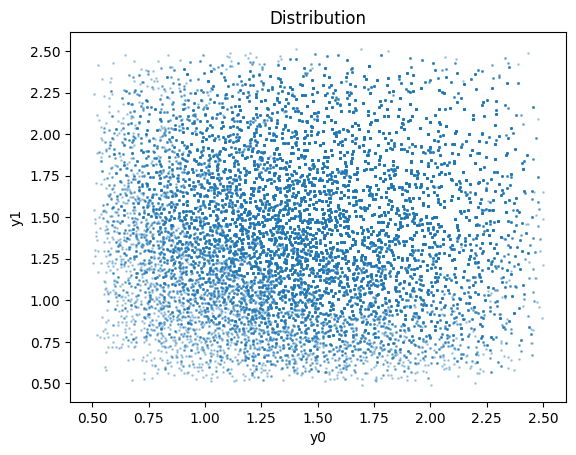

testing triangle with left = -3, right = 3, and mode = 1
(40000, 2)


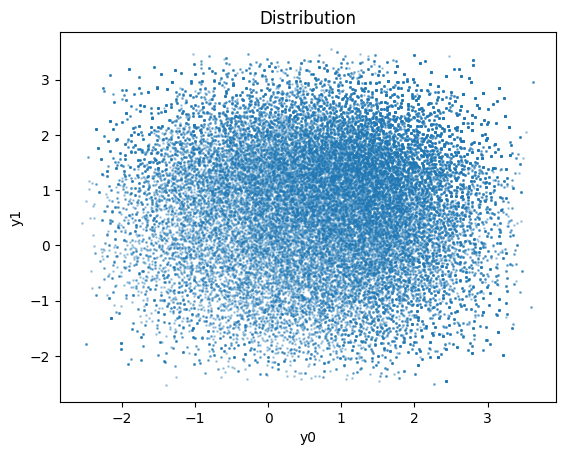

testing triangle with left = -6, right = -3, and mode = -4
(40000, 2)


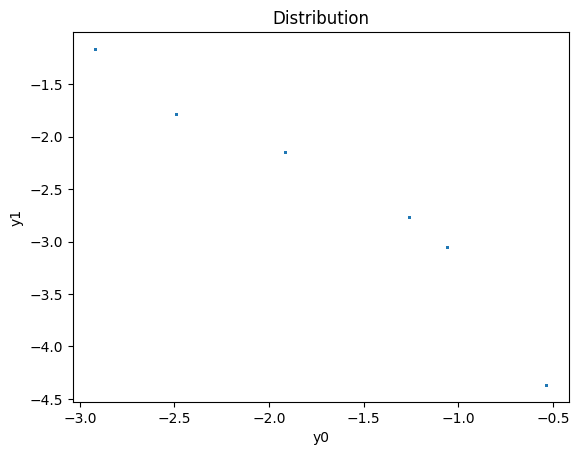

testing triangle with left = 0.1, right = 0.5, and mode = 0.3
(40000, 2)


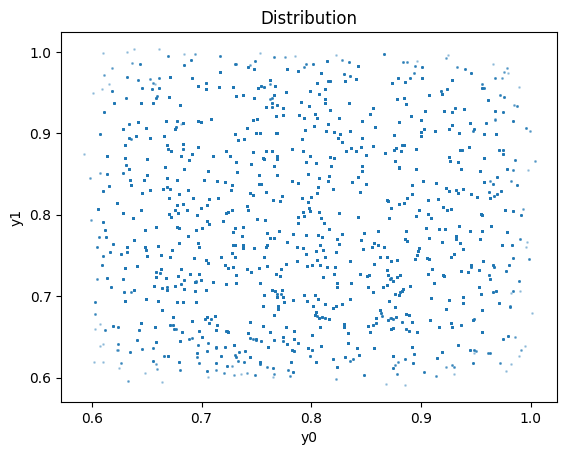

testing triangle with left = -0.5, right = 0.5, and mode = 0
(40000, 2)


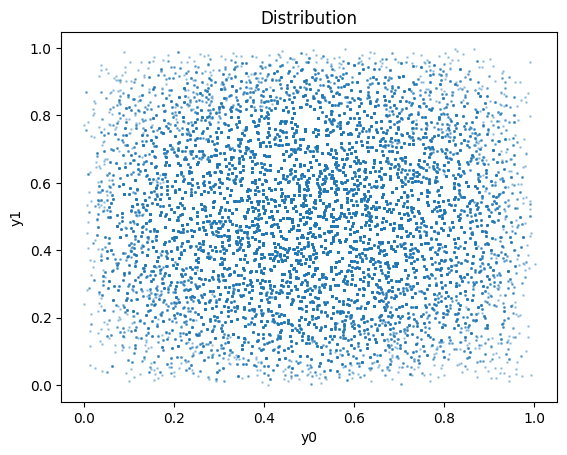

testing triangle with left = 0, right = 20, and mode = 16
(40000, 2)


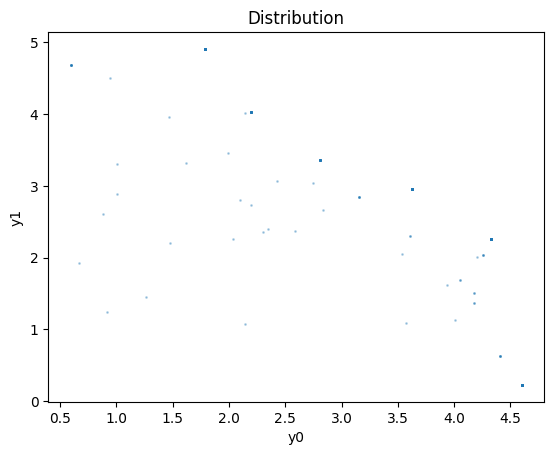

In [ ]:

import scipy
def test_triangle(left,mode,right,threshold=0.1):
    print(f'testing triangle with left = {left}, right = {right}, and mode = {mode}')
    resample_returns = da.resample(y,method='tri',start=0,end=2,left=left,mode=mode,right = right)
    sampled_points = y[resample_returns, 0:2]
    
    print(sampled_points.shape)

    plt.scatter(sampled_points[:, 0], sampled_points[:, 1], alpha=0.3, s=1)
    plt.xlabel('y0')
    plt.ylabel('y1')
    plt.title('Distribution')
    plt.show()

test_triangle(0,1,2)
test_triangle(-3,1,3)
test_triangle(-6,-4,-3)
test_triangle(0.1,0.3,0.5)
test_triangle(-0.5,0,0.5)

test_triangle(0,16,20)

testing uniform with low = 0 and high = 1
        original low = 0, resampled low = 0
        original high = 1, resampled high = 1
    passed


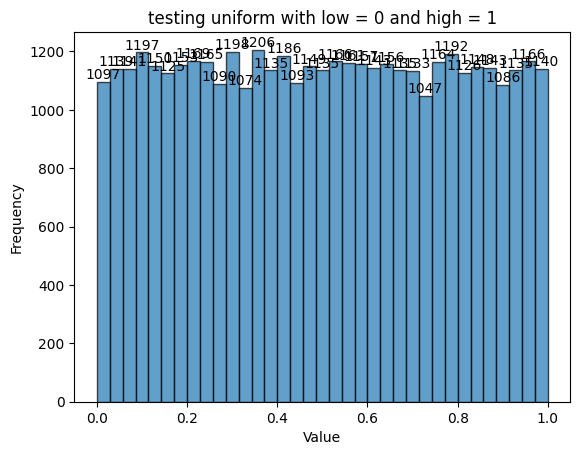

testing uniform with low = -1 and high = 0
        original low = -1, resampled low = -1
        original high = 0, resampled high = 0
    passed


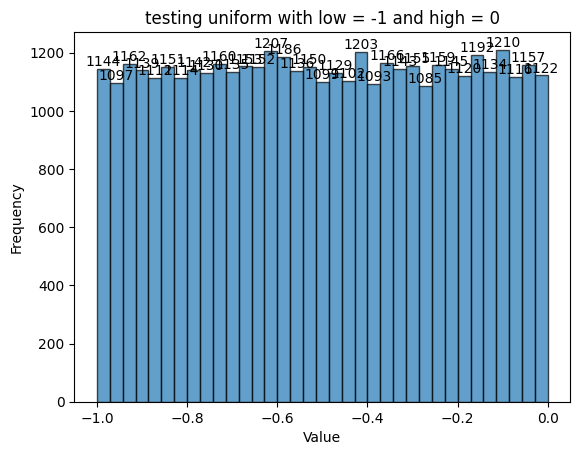

testing uniform with low = -1 and high = 1
        original low = -1, resampled low = -1
        original high = 1, resampled high = 1
    passed


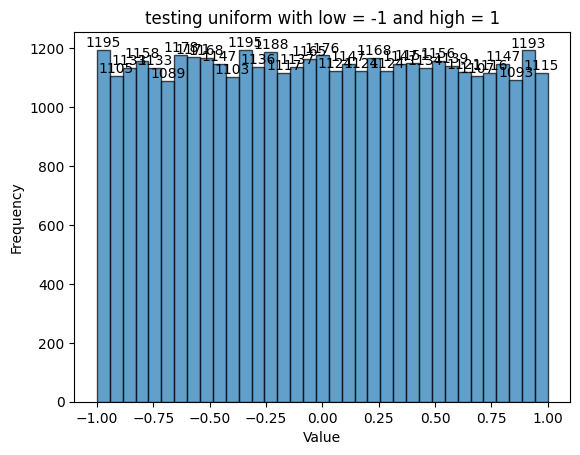

testing uniform with low = 0 and high = 2
        original low = 0, resampled low = 0
        original high = 2, resampled high = 2
    passed


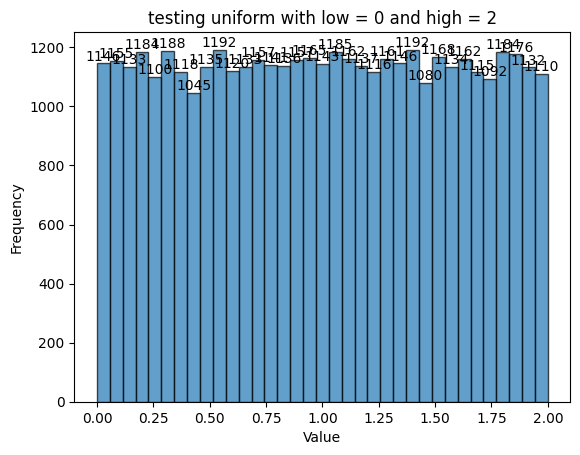

testing uniform with low = -2 and high = 3
        original low = -2, resampled low = -2
        original high = 3, resampled high = 3
    passed


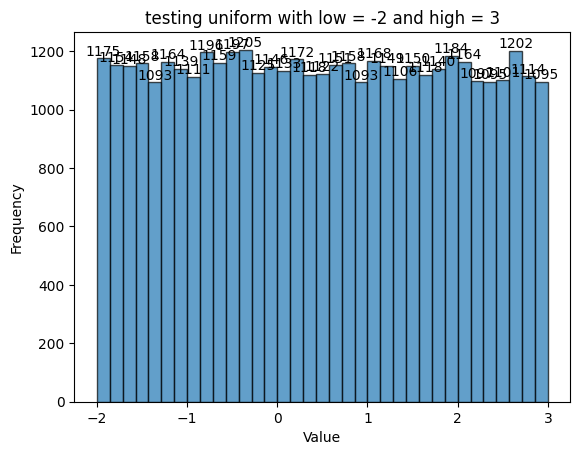

testing uniform with low = -20 and high = 20
        original low = -20, resampled low = -20
        original high = 20, resampled high = 20
    passed


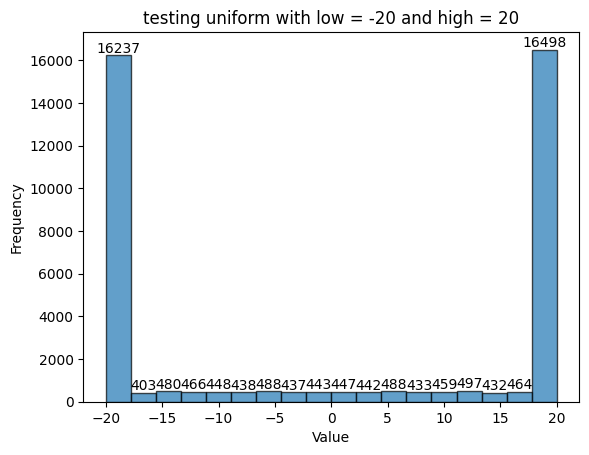

In [ ]:
def test_uniform(low,high,threshold=0.1):
    print(f'testing uniform with low = {low} and high = {high}')
    resample_returns = da.resample(y,method='uni',start=0,end=1,low=low,high=high)
    sampled_points = y[resample_returns, 0]

    sampled_points = (sampled_points - np.min(sampled_points)) / (np.max(sampled_points) - np.min(sampled_points))
    normalized_sampled_points = low + sampled_points * (high - low)

    low_hat = np.min(normalized_sampled_points)
    high_hat = np.max(normalized_sampled_points)

    
    print(f'        original low = {low}, resampled low = {low}')
    print(f'        original high = {high}, resampled high = {high}')
    print('    passed' if(abs(low_hat - low) <= threshold and abs(high_hat - high) <= threshold) else '    failed')

    
    result_array = normalized_sampled_points
    counts, bins, patches = plt.hist(result_array, bins='auto', edgecolor='black', alpha=0.7)
    
    x = np.linspace(min(result_array), max(result_array), 500)
    
    for count, bin_edge in zip(counts, bins):
        bin_center = bin_edge + (bins[1] - bins[0]) / 2
        plt.text(bin_center, count, f'{int(count)}', ha='center', va='bottom')

    plt.title(f'testing uniform with low = {low} and high = {high}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

test_uniform(0,1)
test_uniform(-1,0)
test_uniform(-1,1)
test_uniform(0,2)
test_uniform(-2,3)

test_uniform(-20,20)



testing uniform with low = 0 and high = 1


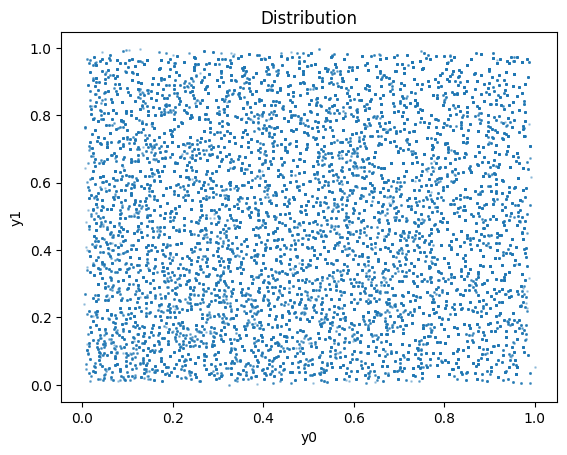

testing uniform with low = -1 and high = 0


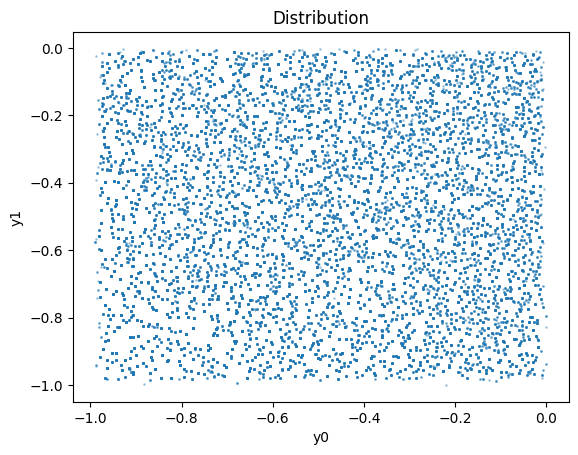

testing uniform with low = -1 and high = 1


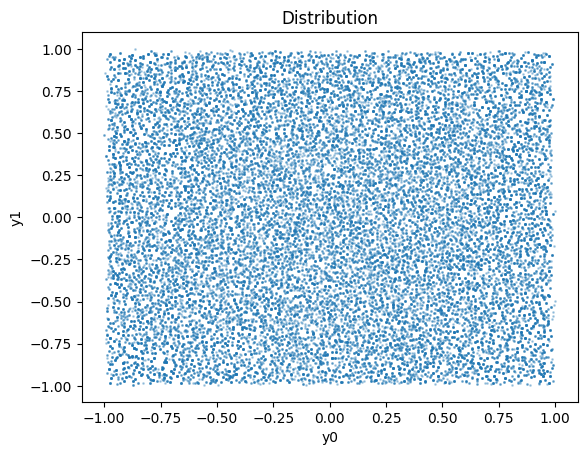

testing uniform with low = -2 and high = 3


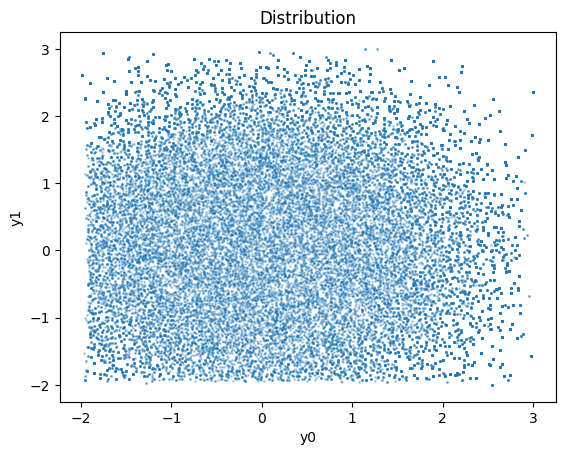

testing uniform with low = 0 and high = 3


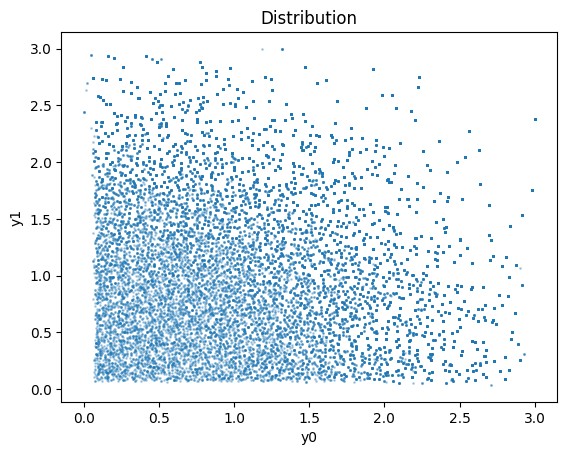

testing uniform with low = -25 and high = -5


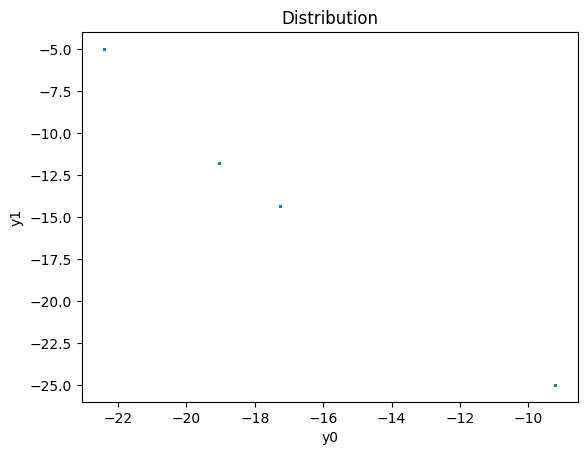

In [ ]:
def test_uniform(low,high,threshold=0.1):
    print(f'testing uniform with low = {low} and high = {high}')
    resample_returns = da.resample(y,method='uni',start=0,end=2,low=low,high=high)
    sampled_points = y[resample_returns, 0:2]
    sampled_points = (sampled_points - np.min(sampled_points)) / (np.max(sampled_points) - np.min(sampled_points))
    normalized_sampled_points = low + sampled_points * (high - low)

    plt.scatter(normalized_sampled_points[:, 0], normalized_sampled_points[:, 1], alpha=0.3, s=1)
    plt.xlabel('y0')
    plt.ylabel('y1')
    plt.title('Distribution')
    plt.show()

test_uniform(0,1)
test_uniform(-1,0)
test_uniform(-1,1)
test_uniform(-2,3)
test_uniform(0,3)
test_uniform(-25,-5)


# STD Gaussian
# 1D testing 

testing std_gauss
(40000, 1)
        original mean = 0, fitted mean = 0.49227487744179843
        original std = 1, fitted mean = 1.9352177981656427
    failed


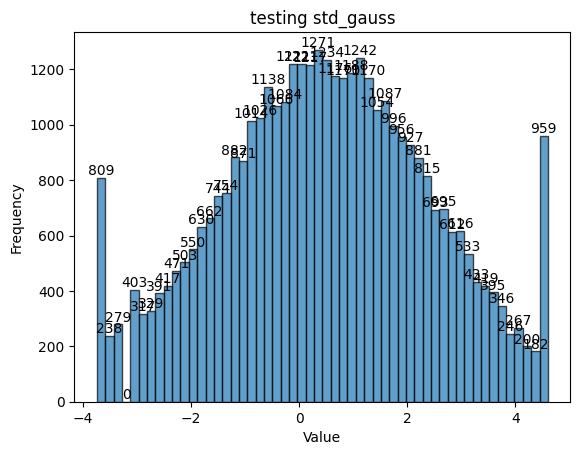

In [ ]:
def test_std_gaussian(threshold=0.1):
    print(f'testing std_gauss')
    resample_returns = da.resample(y,method='std_gauss',start=0,end=1)
    sampled_points = y[resample_returns,0:1]
    print(sampled_points.shape)
    
    
    mu_hat, sigma_hat = norm.fit(sampled_points)
    print(f'        original mean = 0, fitted mean = {mu_hat}')
    print(f'        original std = 1, fitted mean = {sigma_hat}')
    print('    passed' if(abs(sigma_hat - 1) <= threshold and abs(mu_hat - 0) <= threshold) else '    failed')

    counts, bins, patches = plt.hist(sampled_points, bins='auto', edgecolor='black', alpha=0.7)
    
   
    for count, bin_edge in zip(counts, bins):
        bin_center = bin_edge + (bins[1] - bins[0]) / 2
        plt.text(bin_center, count, f'{int(count)}', ha='center', va='bottom')

    plt.title(f'testing std_gauss')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()
test_std_gaussian()


# std gauss 1D FIX

testing std_gauss
(40000, 1)
        original mean = 0, fitted mean = -2.8776980798284056e-17
        original std = 1, fitted mean = 0.9999999999999999
    passed


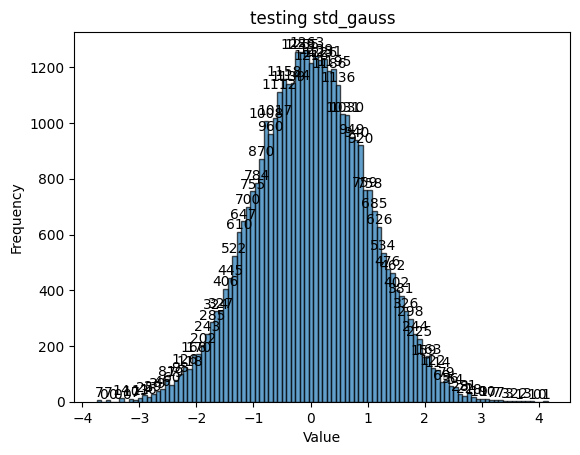

In [ ]:
def test_std_gaussian(threshold=0.1):
    print(f'testing std_gauss')
    resample_returns = resample_fix(y,method='std_gauss',start=0,end=1)
    sampled_points = y[resample_returns,0:1]
    print(sampled_points.shape)
    
    sampled_points = (sampled_points - np.mean(sampled_points)) / np.std(sampled_points) 
    normalized_sampled_points = sampled_points * 1 + 0

    mu_hat, sigma_hat = norm.fit(normalized_sampled_points)
    print(f'        original mean = 0, fitted mean = {mu_hat}')
    print(f'        original std = 1, fitted mean = {sigma_hat}')
    print('    passed' if(abs(sigma_hat - 1) <= threshold and abs(mu_hat - 0) <= threshold) else '    failed')

    counts, bins, patches = plt.hist(normalized_sampled_points, bins='auto', edgecolor='black', alpha=0.7)
    
    for count, bin_edge in zip(counts, bins):
        bin_center = bin_edge + (bins[1] - bins[0]) / 2
        plt.text(bin_center, count, f'{int(count)}', ha='center', va='bottom')

    plt.title(f'testing std_gauss')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()
test_std_gaussian()


# std gauss 2D testing

testing std_gauss
(40000, 2)


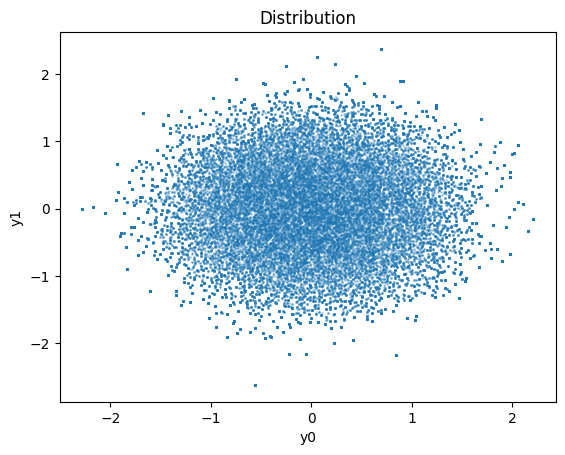

In [ ]:
def test_std_gaussian(threshold=0.1):
    print(f'testing std_gauss')
    resample_returns = da.resample(y,method='std_gauss',start =0,end=2)
    sampled_points = y[resample_returns,0:2]
    print(sampled_points.shape)
    sampled_points = (sampled_points - np.mean(sampled_points)) / np.std(sampled_points) 
    normalized_sampled_points = sampled_points * 1 + 0
    plt.scatter(normalized_sampled_points[:, 0], normalized_sampled_points[:, 1], alpha=0.3, s=1)
    plt.xlabel('y0')
    plt.ylabel('y1')
    plt.title('Distribution')
    plt.show()
test_std_gaussian()
